# Reading Libraries

In [197]:
#Reading Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [198]:
#Reading Data
path = "./Data/Spotify_1921_to_2020.csv"
df_raw = pd.read_csv(path)

In [199]:
#scaling
scale_cols = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
for col in scale_cols:
    maxVal = df_raw[col].abs().max()
    df_raw[col] = df_raw[col]/maxVal

#add weighting features1 based on statistical test on relationship with popularity
weight_cols = ['energy', 'danceability', 'speechiness']
w_rate = 3
for col in weight_cols:
    df_raw[col] = w_rate*df_raw[col]
'''
#add weighting features2
weight_cols = ['loudness', 'speechiness']
weight_cols = ['loudness']
w_rate = 1.5
for col in weight_cols:
    df_raw[col] = w_rate*df_raw[col]
'''
print(df_raw.select_dtypes(include = np.number).abs().max())

acousticness           0.996
danceability           2.964
duration_ms            1.000
energy                 3.000
explicit               1.000
instrumentalness       1.000
key                    1.000
liveness               1.000
loudness               1.000
mode                   1.000
popularity             1.000
speechiness            2.907
tempo                  1.000
valence                1.000
year                2020.000
dtype: float64


# Data Preparation

In [200]:
#data preprocessing
def preprocessing(df, topN=20, startYear=1955):
    #use data from 1955
    df = df[df['year']>=startYear]
    df = df.select_dtypes(include = np.number)
    df = df.groupby('year').apply(lambda x: x.nlargest(topN, ['popularity']))
    df.drop(['year'], axis = 1, inplace = True)
    df = df.groupby('year').agg(['mean'])
    df.columns = [col[0] for col in df.columns.values]
    df.reset_index(inplace = True)
    return df

In [201]:
#set parameter
topN = 100
startYear = 1990
targetYear = 2020

#preprocess data
df = preprocessing(df_raw, topN=topN, startYear=startYear)
print(df.head())
print(df.columns)

   year  acousticness  danceability  duration_ms   energy  explicit  \
0  1990      0.206522       1.64784     0.049620  2.00019      0.05   
1  1991      0.222771       1.66038     0.050100  1.88469      0.06   
2  1992      0.251523       1.79760     0.047129  1.87485      0.15   
3  1993      0.192939       1.81056     0.046679  1.87548      0.14   
4  1994      0.225749       1.69359     0.046071  1.89226      0.16   

   instrumentalness       key  liveness  loudness  mode  popularity  \
0          0.052565  0.445455  0.171580 -0.146606  0.78      0.6378   
1          0.032905  0.538182  0.182937 -0.159454  0.67      0.6632   
2          0.018784  0.453636  0.182672 -0.147418  0.76      0.6549   
3          0.070677  0.512727  0.174003 -0.161816  0.72      0.6638   
4          0.037245  0.526364  0.185944 -0.146506  0.68      0.6708   

   speechiness     tempo   valence  
0     0.176862  0.501952  0.521157  
1     0.152025  0.484472  0.539474  
2     0.218688  0.487823  0.589530 

In [202]:
#add new feature for time-series regression
def add_n_years(df, startYear):
    df['n_years'] = df['year'] - startYear
    return df

#train-test data preparation
def get_train(df, targetYear = 2020):
    return df[df['year']<targetYear]

def get_test(df, targetYear = 2020, cols = []):    
    return df[df_raw['year'] == targetYear][cols]

In [203]:
#add new feature : # of years from 1921
df = add_n_years(df, startYear)
df_raw = add_n_years(df_raw, startYear)

#get train, test data
train = get_train(df)
cols = train.columns
test = get_test(df_raw, targetYear = targetYear, cols = train.columns)

# Building Prediction Model: Step 1

In [204]:
#sub predictive model
reg_model = LinearRegression
#reg_model = RandomForestRegressor
def sub_model( df, test_x,  y_col, x_col = 'n_years', mlmodel = LinearRegression):
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    model = mlmodel()
    model.fit(x,y)
    test_y = model.predict(test_x.reshape(-1, 1))
    return model, test_y

In [205]:
#apply sub_model to all features
cols = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo', 'valence']
drop_cols = ['explicit', 'key', 'mode', 'popularity', 'explicit'] # 
#remove columns in drop_cols
cols = [col for col in cols if col not in drop_cols]
def regression_model(df, test_x, cols, sub_model = sub_model, mlmodel = LinearRegression):
    pred = {}
    models = {}
    for col in cols:
        models[col], pred[col] = sub_model(df, test_x, y_col = col, mlmodel = mlmodel )#, mlmodel = RandomForestRegressor())
    return models, pd.DataFrame.from_dict(pred)

In [206]:
#apply regression model 
models, pred_data = regression_model(train, test_x = test.n_years.iloc[0].reshape(-1,1) , cols = cols, mlmodel = reg_model)
print(pred_data)

   acousticness  danceability  duration_ms    energy  instrumentalness  \
0      0.267189      1.952311     0.040811  1.777176          0.032851   

   liveness  loudness  speechiness     tempo   valence  
0   0.18186 -0.114915     0.278702  0.476793  0.441261  


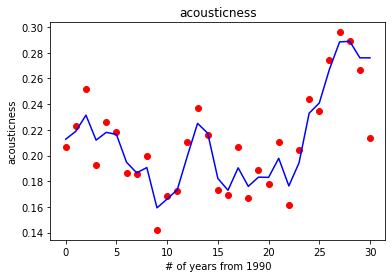

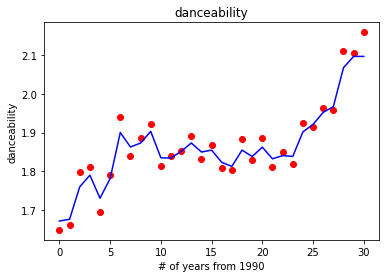

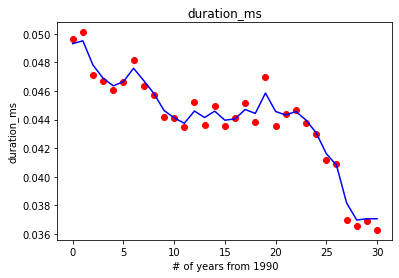

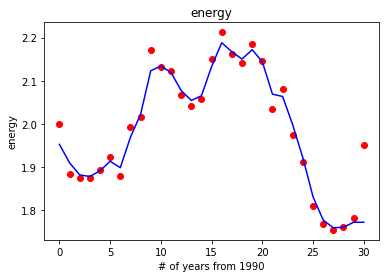

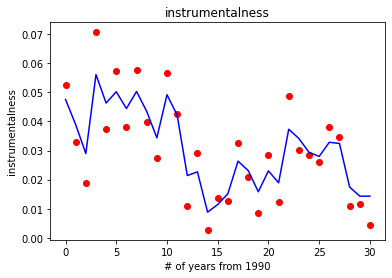

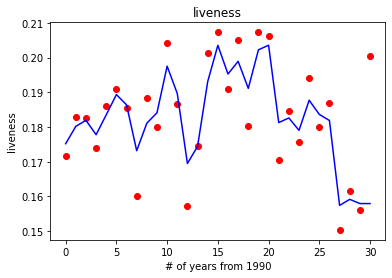

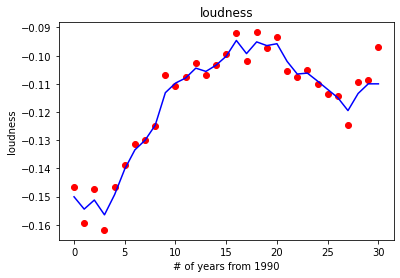

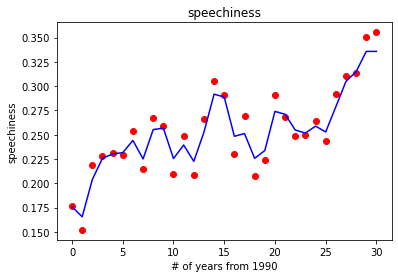

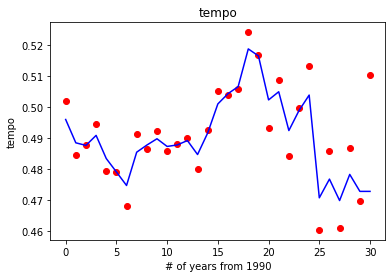

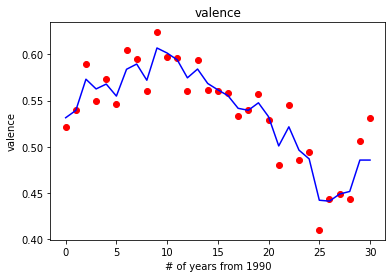

In [207]:
#Show prediction model - Random Forest Regression
for col in cols:
    model = models[col]
    x = df['n_years'].values.reshape(-1, 1)
    y = df[col].values
    pred_y = model.predict(x)
    plt.scatter(x, y, color = 'red')
    plt.plot(x, pred_y, color = 'blue')
    plt.title(f'{col}')
    plt.xlabel(f'# of years from {startYear}')
    plt.ylabel(col)
    plt.show()

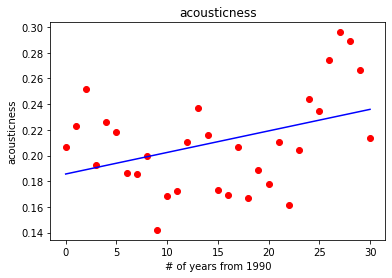

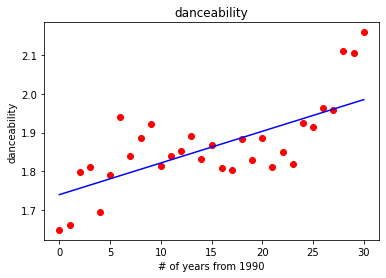

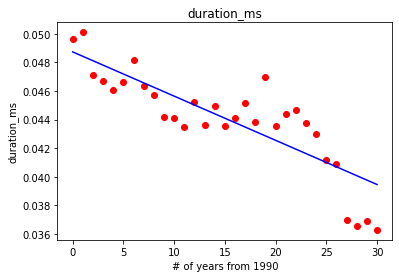

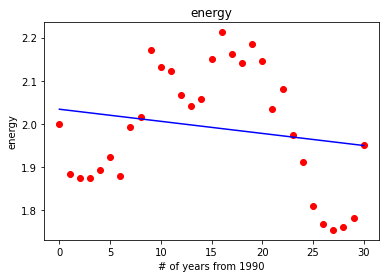

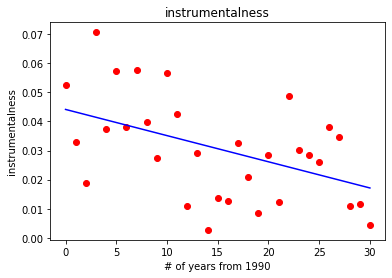

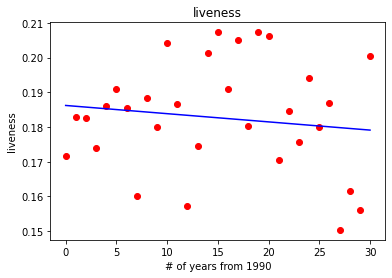

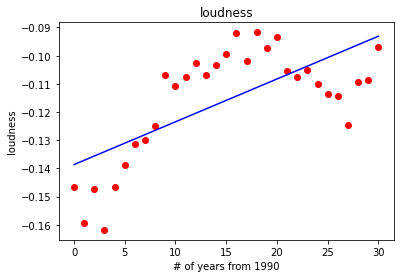

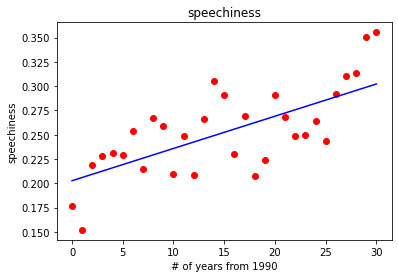

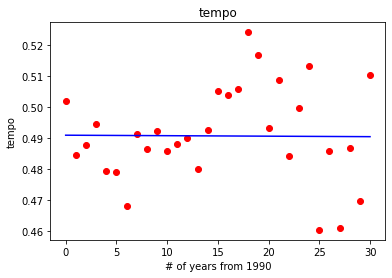

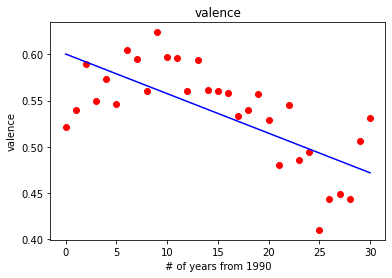

In [186]:
#Show prediction model - Linear Regression
for col in cols:
    model = models[col]
    x = df['n_years'].values.reshape(-1, 1)
    y = df[col].values
    pred_y = model.predict(x)
    plt.scatter(x, y, color = 'red')
    plt.plot(x, pred_y, color = 'blue')
    plt.title(f'{col}')
    plt.xlabel(f'# of years from {startYear}')
    plt.ylabel(col)
    plt.show()

By comparing two different regression models(Linear Regression and Random Forest Regression), it shows that even though linear regression is simpler, it reflects tendency better and avoids overfitting problems. 
From the above graphs, some features have a linear relationship with time, so they increase or decrease over time.

# Building Prediction Model: Step2

In [187]:
#cosine similarity
def cosim(a, b):
    return np.dot(a.values.T, b.values)/((np.sqrt(np.sum(a**2)))*(np.sqrt(np.sum(b**2))))

In [188]:
#get new music data
new_music_df = df_raw[df_raw['year'] == targetYear]

#add cosine_similarity to dataframe
new_music_df['cosine_similarity'] = new_music_df.apply(lambda x: cosim(x[cols], pred_data.iloc[0]), axis = 1)

#Sort dataframe by 'popularity'
new_music_df.sort_values(by = ['popularity'], ascending = False, inplace = True)
print(new_music_df.head())

       acousticness                         artists  danceability  \
87540        0.0847                ['Travis Scott']         2.523   
87547        0.1410     ['The Weeknd', 'Daft Punk']         2.037   
87544        0.6950                ['James Arthur']         1.074   
87546        0.4140  ['The Chainsmokers', 'Halsey']         2.244   
87541        0.0689                 ['Post Malone']         1.668   

       duration_ms  energy  explicit                      id  \
87540     0.045126   2.184         1  6gBFPUFcJLzWGx4lenP6h2   
87547     0.042649   1.761         1  7MXVkk9YMctZqd1Srtv4MB   
87544     0.039135   1.671         0  5uCax9HTNlzGybIStD3vDh   
87546     0.045334   1.572         0  7BKLCZ1jbUBVqRi2FVlTVw   
87541     0.041334   1.614         1  75ZvA4QfFiZvzhj2xkaWAh   

       instrumentalness       key  liveness  ...  mode                  name  \
87540          0.000000  0.636364    0.1490  ...     1            goosebumps   
87547          0.000006  0.636364    0.1

/var/folders/fv/5lghyf396mx2y_sv1wq3xm3r0000gn/T/ipykernel_1884/1882198446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_music_df['cosine_similarity'] = new_music_df.apply(lambda x: cosim(x[cols], pred_data.iloc[0]), axis = 1)
/var/folders/fv/5lghyf396mx2y_sv1wq3xm3r0000gn/T/ipykernel_1884/1882198446.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_music_df.sort_values(by = ['popularity'], ascending = False, inplace = True)


In [193]:
#Ouput of Step2
end = 7
pop_means = []
cos_means = []
x_lab = []
for i in range(1,end):
    x_lab.append(topN*i)
    print(f"<Top {1+topN*(i-1)} to {topN*i}>")
    pop_mean = new_music_df.iloc[topN*(i-1):topN*i]['popularity'].mean()
    pop_means.append(pop_mean)
    print(f"Mean of Popularity: {pop_mean}")
    cos_mean = new_music_df.iloc[topN*(i-1):topN*i]['cosine_similarity'].mean()
    cos_means.append(cos_mean)
    print(f"Mean of Cosine Similarity: {cos_mean}\n")    

<Top 1 to 100>
Mean of Popularity: 0.7695000000000003
Mean of Cosine Similarity: 0.9613358184577764

<Top 101 to 200>
Mean of Popularity: 0.7162999999999999
Mean of Cosine Similarity: 0.9586021273450693

<Top 201 to 300>
Mean of Popularity: 0.6898000000000002
Mean of Cosine Similarity: 0.9598233907811127

<Top 301 to 400>
Mean of Popularity: 0.6679999999999998
Mean of Cosine Similarity: 0.9558595834614284

<Top 401 to 500>
Mean of Popularity: 0.6544000000000003
Mean of Cosine Similarity: 0.9459902337282771

<Top 501 to 600>
Mean of Popularity: 0.6433999999999999
Mean of Cosine Similarity: 0.9160196224625694



# Result

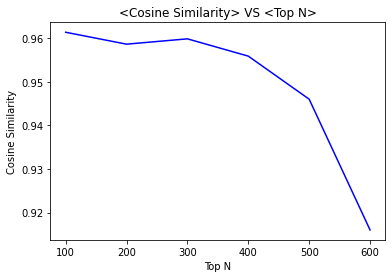

In [195]:
#plot consine similarity depending on popularity
plt.plot(x_lab, cos_means, color = 'blue')
plt.title('<Cosine Similarity> VS <Top N>')
plt.xlabel('Top N')
plt.ylabel('Cosine Similarity')
plt.show()

From the result of the experiment with the prediction model, predicted music data has similar characteristics to those of the new most popular songs. It means that the predicted data captures the trend of new popular music.<br>
The above plot shows that as cosine similarity between predicted data and the new most popular music data decreases, a song's popularity also decreases. Cosine similarities from the predictive model cannot delicately estimate the popularity of a song, but the result sufficiently shows the tendency, which can be considered as the relationship between popularity and similarity.